In [249]:
import numpy as np
import sys
import pyvista as pv
import os
import torch
import matplotlib.pyplot as plt

In [250]:
class IGBReader:
    """ 
    class IGBReader: reads an igb file
    """
    
    def __init__(self):
        self.__header: dict     = None
        self.__data: np.ndarray = None
        self.__filename: str    = None
        self.__ndiff: int       = 0
        self.__head_size: int   = 256

    def read(self,igbfname: str):
        """ read(igbfname):
        reads the IGB file igbfname and fills the header and data attributes.
        """
        self.__filename = igbfname
        try:
            parsed_header = self.__parse_header()

            #now read the data and create an array        
            with open(self.__filename,'rb') as f:
                y = np.fromfile(f,'f4')
            y        = y[self.__head_size:]
            nt       = parsed_header['t']
            nx       = parsed_header['x']            
            nentries = y.shape[0]
            ntot     = nt*nx
            self.__ndiff = nentries-ntot
            
            if(nentries>ntot):
                # More values than expected
                print('Warning: problem with the igb file',flush=True)
                print('Discarding the last {} elements'.format(self.__ndiff))
                y  = y[:ntot] 
            elif(nentries<ntot):  
                #less values than expected nentries<ntot
                nt = nentries//nx
                if(nt==0):
                    print('ERROR: y too short!')
                    print('({} elements; expected {} (problems with the igb file)'.format(nentries,ntot))
                    sys.exit()
                else:
                    ntot     = nt*nx
                    y        = y[:ntot]
                    missing = nentries%nx
                    print('Warning: problem with the ifgb file',flush=True)                    
                    print('Missing {} elements to reach {}'.format(missing,parsed_header['t'])) 
                    print('Reshaping to {} time steps'.format(nt))
            else:
                print('file is ok')
            parsed_header['t'] = nt
            y = np.reshape(y,(nt,nx))
            self.__header = parsed_header
            self.__data   = np.copy(y)
        except ValueError:
            print('error with {0}'.format(self.__filename) )


    def header(self) ->dict :
        """header(): returns the header dict"""
        return(self.__header)

    def data(self) ->np.ndarray :
        """data(): returns the numpy array that contains the data"""
        return(self.__data)

    def filename(self) ->str :
        """filename(): returns the file name that contained the data"""
        return(self.__filename)

    def ndiff(self) ->int :
        """ndiff(): returns the number of entries in excess/missing in the original file"""
        return(self.__ndiff)

    def org_t(self) ->float:
        """org_t(): returns the time origin"""
        return(self.__header['org_t'])
        
    def nt(self) -> int:
        """nt(): returns the total number of time steps"""
        return(self.__header['t'])
    
    def nx(self) -> int:
        """nx(): returns the x space dimension"""
        return(self.__header['x'])

    def ny(self) -> int:
        """ny(): returns the y space dimension"""
        return(self.__header['y'])

    def nz(self) -> int:
        """nz(): returns the z space dimension"""
        return(self.__header['z'])

    def dim_t(self) ->float:
        """dim_t(): returns the temporal dimension""" 
        return(self.__header['dim_t'])
    
    def dt(self) ->float:
        """dt(): returns the time step (nan if nt=1)"""
        if(self.nt()>1):
            return(self.dim_t()/(self.nt()-1))
        else:
            return(np.nan)

    def timevalues(self,shifted:bool = False) ->np.ndarray:
        """timevalues(shifted=False): returns a numpy array with the time axis
        if shifted = True, it shifts the time values to have 0 as the first one
        """
        tline = self.dt()*np.arange(self.nt())
        if shifted:
            return(tline)
        else:
            return(self.org_t()+tline)


    def __parse_header(self) ->dict :
        ''' parse_header():
        parses the header of the IGB file.
        '''
        parsed_header = {}
        int_keys = ['x','y','z','t']
        try:
            with open(self.__filename,'rb') as f:
                header = f.read(self.__head_size)
            header = header.decode("utf-8")
            for jj in header.strip().split():
                [key,val]=jj.split(':')
                if(val.isdigit()):
                    if key in int_keys:
                        parsed_header[key]=int(val)
                    else:
                        parsed_header[key]=float(val)
                else:
                    parsed_header[key]=val            
            # Now add some keys that might miss
            if not 'y' in parsed_header.keys():
                parsed_header['y'] = int(1)            
            if not 'z' in parsed_header.keys():
                parsed_header['z'] = int(1)
            if not 'org_t' in parsed_header.keys():
                parsed_header['org_t'] = float(0)
            if not 'dim_t' in parsed_header.keys():
                parsed_header['dim_t'] = float(parsed_header['t']-1 )
            if not 'unites_x' in parsed_header.keys():
                parsed_header['unites_x'] = 'unk'
            if not 'unites_y' in parsed_header.keys():
                parsed_header['unites_y'] = 'unk'
            if not 'unites_z' in parsed_header.keys():
                parsed_header['unites_z'] = 'unk'
            if not 'unites_t' in parsed_header.keys():
                parsed_header['unites_t'] = 'unk'
            if not 'unites' in parsed_header.keys():
                parsed_header['unites'] = 'unk'
            if not 'facteur' in parsed_header.keys():
                parsed_header['facteur'] = 1
            if not 'zero' in parsed_header.keys():
                parsed_header['zero'] = 0
            return(parsed_header)
                                  
        except Exception as err:
            print(f"Unexpected {err=}, {type(err)=}")
            raise

In [251]:
reader = IGBReader()
reader.read("./vm.igb")
carp_solution = reader.data()

cor_solution = torch.load("./Vm.pt").numpy()

file is ok


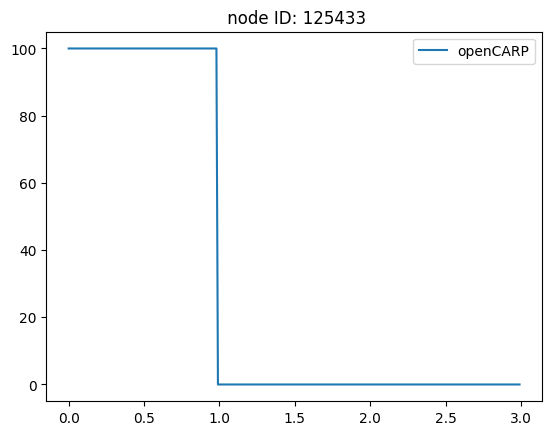

In [252]:
Istim = torch.load("./Istim.pt").numpy()

largest_diff_node = 125433
istim_values = []
for i in range(Istim.shape[0]):
    istim_values.append(Istim[i][largest_diff_node])
plt.plot([i for i in np.arange(0, 3, 0.01)], istim_values, label="openCARP")
plt.title(f" node ID: {largest_diff_node}")
plt.legend()

plt.show()

In [253]:
cor_solution.shape

(301, 637480)

In [254]:
carp_solution.shape

(301, 637480)

In [255]:
# np.argsort(np.sum(carp_solution - cor_solution, axis=1))[-1]

In [256]:
carp = []
cor = []
largest_diff_node = 125433
for i in range(0, 11):
    diff = cor_solution[i][largest_diff_node] - carp_solution[i][largest_diff_node]
    print(i, cor_solution[i][largest_diff_node], carp_solution[i][largest_diff_node], diff)

0 -86.2 -86.2 0.0
1 -85.44611 -86.199554 0.75344086
2 -84.75125 -85.56699 0.8157425
3 -84.109314 -84.70329 0.5939789
4 -83.51489 -83.75555 0.24065399
5 -82.96318 -82.77769 -0.18549347
6 -82.450005 -81.789505 -0.6604996
7 -81.97167 -80.79829 -1.1733856
8 -81.52486 -79.806694 -1.7181625
9 -81.106674 -78.8157 -2.2909775
10 -80.71455 -77.82564 -2.8889084


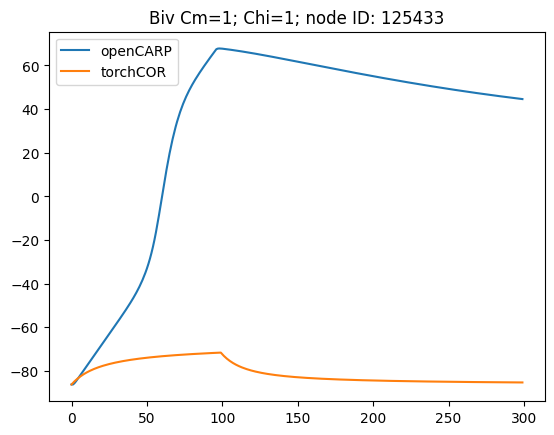

In [258]:
for node_id in range(125433, 125434):
    carp = []
    cor = []
    largest_diff_node = node_id
    for i in range(300):
        carp.append(carp_solution[i][largest_diff_node])
        cor.append(cor_solution[i][largest_diff_node])
        
    plt.plot(carp, label="openCARP")
    plt.plot(cor, label="torchCOR")
    plt.title(f"Biv Cm=1; Chi=1; node ID: {largest_diff_node}")
    plt.legend()

    plt.show()

In [248]:
diff_list = []
for i in range(80):
    # diff = np.linalg.norm(carp_solution[i] - cor_solution[i]) / np.linalg.norm(carp_solution[i])
    diff = (carp_solution[i] - cor_solution[i]).max()
    diff_list.append(diff)

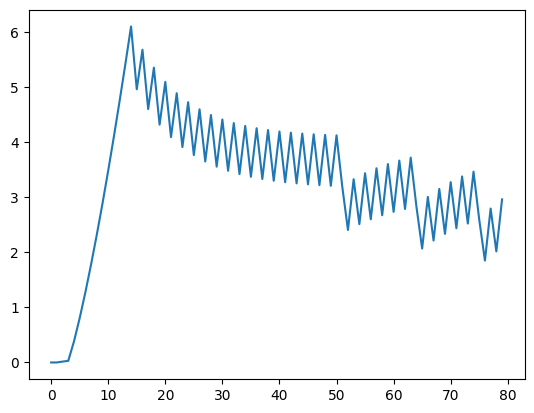

In [108]:
plt.plot(diff_list)

In [20]:
np.where((carp_solution[70] - cor_solution[70]) > 128)

(array([], dtype=int64),)

In [21]:
carp_solution[70][29336] - cor_solution[70][29336]

np.float32(0.0011291504)